In [1]:

# graph neural network 
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import KDTree


import torch
from torch import tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, Linear, GraphConv

import rootutils
root = rootutils.setup_root("./scripts/", dotenv=True, pythonpath=True,  indicator =  [".project-root"], cwd = True)




from scripts.nb_functions import find_filtered_voronoi_neighbor_knn_limited_mask

from scripts.models import CustomGNN
from scripts.environment import Environment

In [2]:
# positions = np.load('quarters/positions.npy')
# print(positions.shape)

# # load data

# data = []
# for i in range(4):
#     for subpart in ["both", "BMP", "FGF"]:
#         dat = np.load(f"quarters/quarter_{i}_{subpart}_SMAD_and_ERK.npy")
#         dat = dat.swapaxes(1, 2)
#         data.append(dat)


# data = np.array(data)

positions = []

data = []

for i in range(10):
    positions.append(np.load(f"positions/random_{i}_positions.npy"))
    SMAD_ERK = np.load(f"positions/random_{i}_SMAD_and_ERK.npy")
    SMAD_ERK = SMAD_ERK.swapaxes(1, 2)

    # SMAD_ERK[:,:,0] *= 100.
    # SMAD_ERK[:,:,1] *= 100.

    d = SMAD_ERK[:1000,:,:]
    data.append(d)
    print(d.shape)
    

(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)
(1000, 1000, 2)


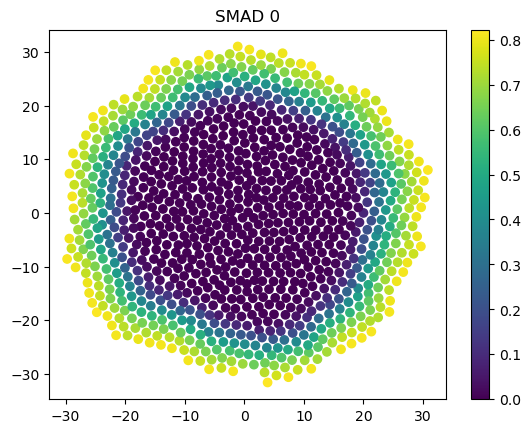

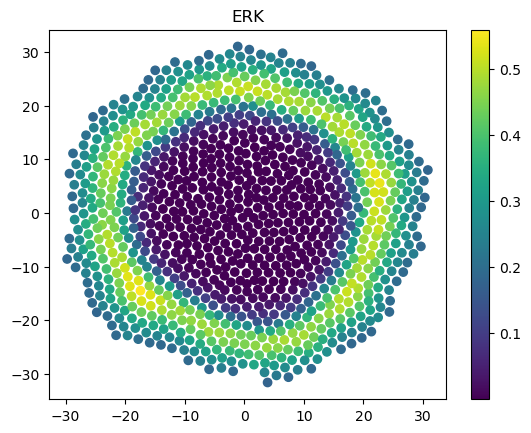

In [3]:
i = 0

time = 400

plt.scatter(positions[i][:, 0], positions[i][:, 1], c=data[i][time,:,0], cmap="viridis")
plt.colorbar()
plt.title(f"SMAD {i}")
plt.show()
plt.scatter(positions[i][:, 0], positions[i][:, 1], c=data[i][time,:,1], cmap="viridis")
plt.colorbar()
plt.title(f"ERK")
plt.show()

TODO:

Get data from the actual system of interest

PINN!

Encoding?


IDEA:

Get latent space representation. Learn taylor paramaters.


Physics Informed Symbolic(?) Embedding/Latent(-something) Internally-recurrent Parsimonious Graph Neural Cellular Automata

In [22]:
stepsize = 5

for i in range(2,10):
    model = CustomGNN(3, [8], 2, aggregation="mean", biases = True)

    env = Environment(data, positions, lr = 0.001, weight_gain = 1e-7, stepsize = stepsize, iterative_training = False)

    env.set_model(model)

    env.train(100)

    env = Environment(data, positions, lr = 0.0001, weight_gain = 1e-7, stepsize = stepsize, iterative_training = False)

    env.set_model(model)

    env.train(100)
    torch.save(model.state_dict(), f"model{i}.pth")


(1000, 8) (1000, 8)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 9) (1000, 9)
(1000, 8) (1000, 8)
(1000, 9) (1000, 9)
5
0.05 loss: 0.005697714186680969
0.2446000874042511
10
0.1 loss: 0.005584556674875785
0.2440624088048935
15
0.15 loss: 0.0055383320614055265
0.24364696443080902
20
0.2 loss: 0.0055056648307072464
0.24337130784988403
25
0.25 loss: 0.005477874310599873
0.2431047260761261
30
0.3 loss: 0.005454503934743116
0.24288569390773773
35
0.35 loss: 0.005430033525044564
0.24267390370368958
40
0.4 loss: 0.005413542567112017
0.24249541759490967
45
0.45 loss: 0.005397499080572743
0.24232779443264008
50
0.5 loss: 0.005375846285460284
0.24211058020591736
55
0.55 loss: 0.0053570788622892
0.24188728630542755
60
0.6 loss: 0.005342653366824379
0.2416912466287613
65
0.65 loss: 0.005327991857484449
0.24152883887290955
70
0.7 loss: 0.005318074272508966
0.24135982990264893
75
0.75 loss: 0.005307948413246777
0.24118

In [29]:
# save model

# load model
model = CustomGNN(3, [8], 2, aggregation="mean", biases = True)
model.load_state_dict(torch.load("models/model3.pth"))


<All keys matched successfully>

(1000, 9) (1000, 9)


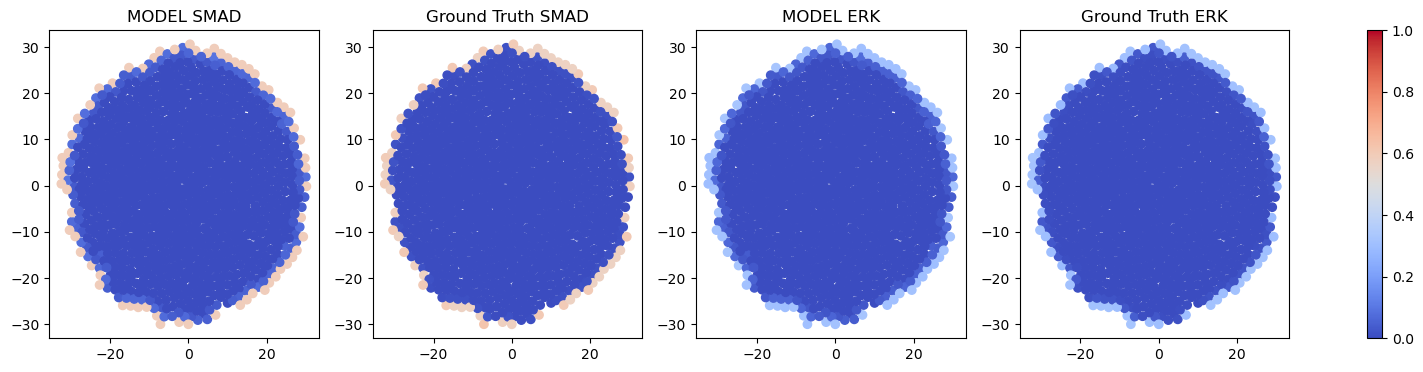

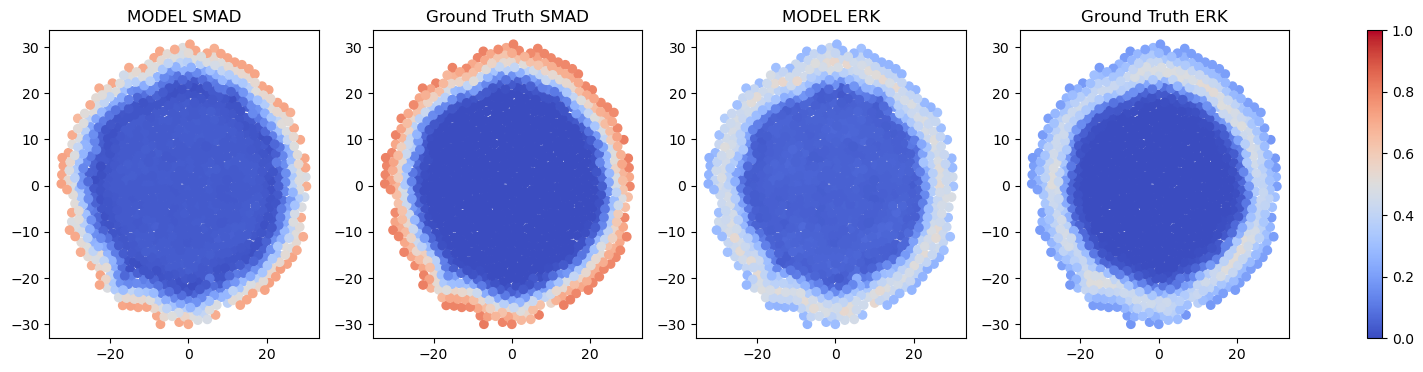

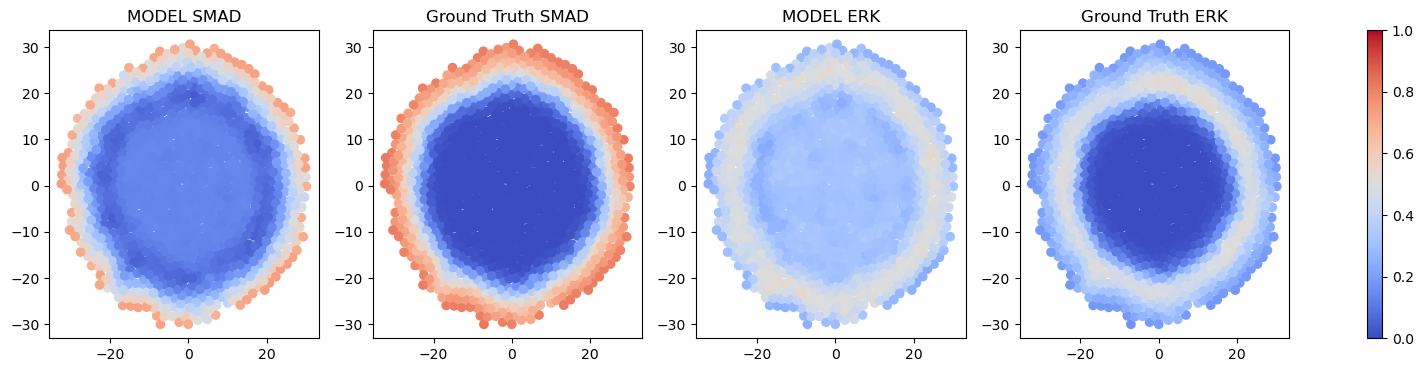

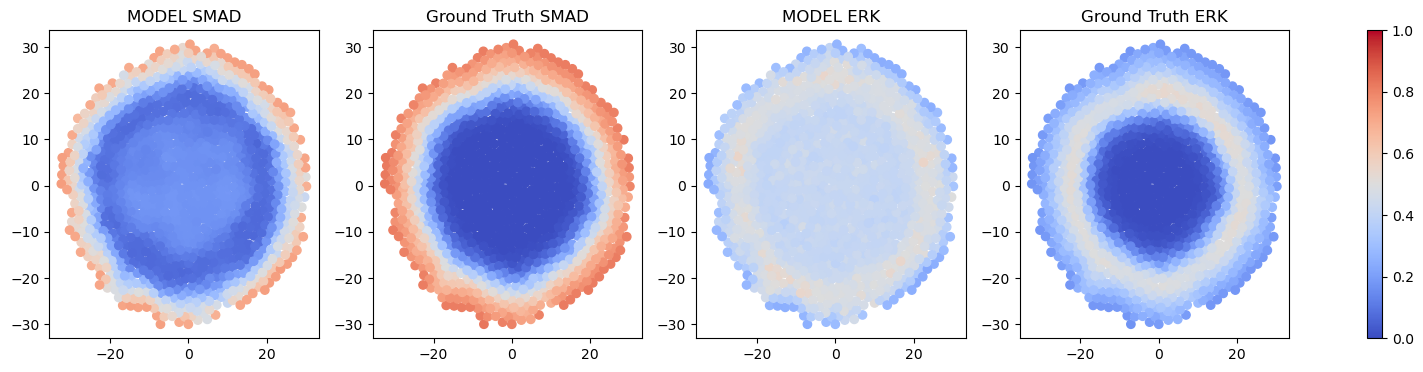

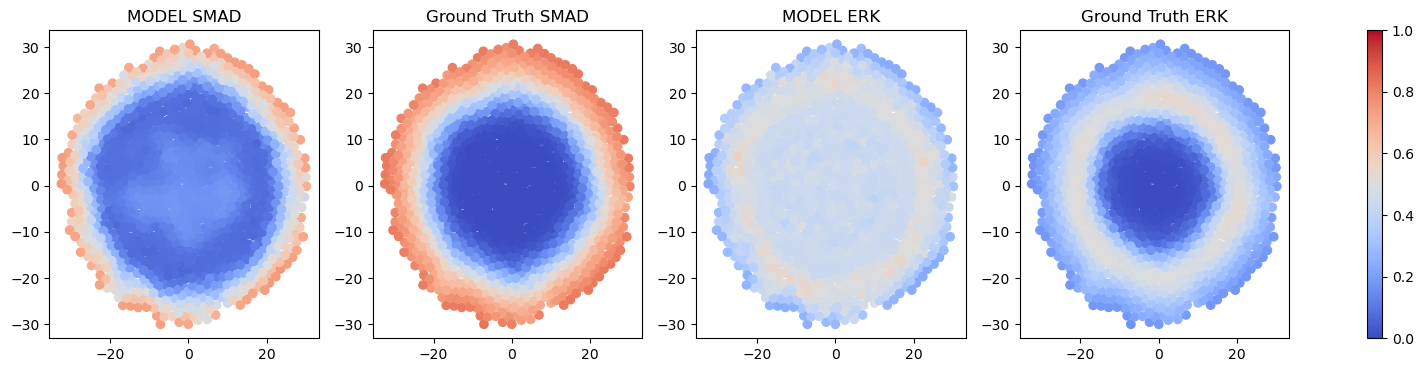

In [ ]:
model.eval()


ii = np.random.randint(0, len(env.ys)) 

poss = env.positions[ii]
actposs = poss.copy()
y_val = env.ys[ii]

# mask = np.abs(poss[:,0]) > 1.2
# poss = poss[mask]



edges, edge_weights, border = env.get_edges(poss)

X = torch.zeros((poss.shape[0],2), dtype=torch.float32)
# X = y_val[100]
for i in range(int(1000/stepsize)):
    out = env.call_own_model(X, edges, edge_weights, border)

    out = out.detach().numpy()
    if (i-1) % (int(1000/stepsize/5)) == 0:
        fig, axs = plt.subplots(1, 4, figsize=(20, 4))
        gt = y_val[(i+1)*stepsize][:]

        # vmin = np.min([np.min(gt), np.min(out[:,smad_erk])])
        # vmax = np.max([np.min(gt), np.min(out[:,smad_erk])])
        vmin = 0.
        vmax = 1.


        axs[0].scatter(poss[:,0], poss[:,1], c=out[:,0], cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[0].set_title('MODEL SMAD')
        axs[1].scatter(actposs[:,0], actposs[:,1], c=gt[:,0], cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[1].set_title('Ground Truth SMAD')

        axs[2].scatter(poss[:,0], poss[:,1], c=out[:,1], cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[2].set_title('MODEL ERK')
        axs[3].scatter(actposs[:,0], actposs[:,1], c=gt[:,1], cmap='coolwarm', vmin=vmin, vmax=vmax)
        axs[3].set_title('Ground Truth ERK')

        #colorbar
        sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=vmin, vmax=vmax))
        sm._A = []
        fig.colorbar(sm, ax=axs, orientation='vertical')
        plt.show()



    X = torch.tensor(out, dtype=torch.float32).squeeze(1)

[6, 8, 2]


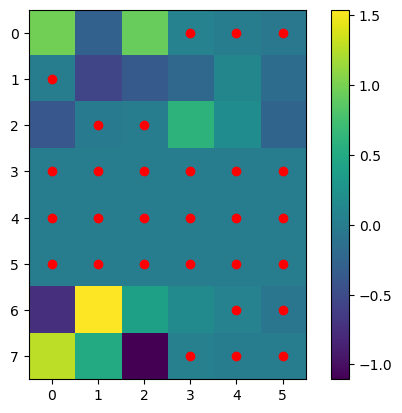

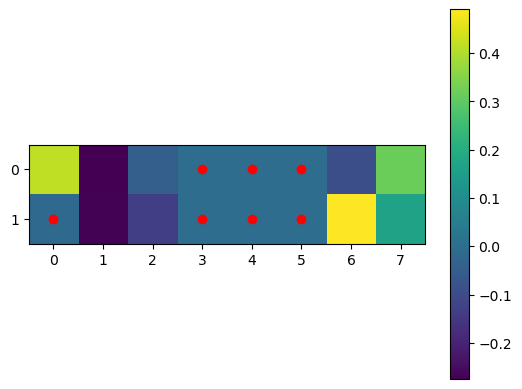

C:\Users\jakob\AppData\Local\Temp\ipykernel_40580\2671785016.py:90: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('coolwarm', 10)


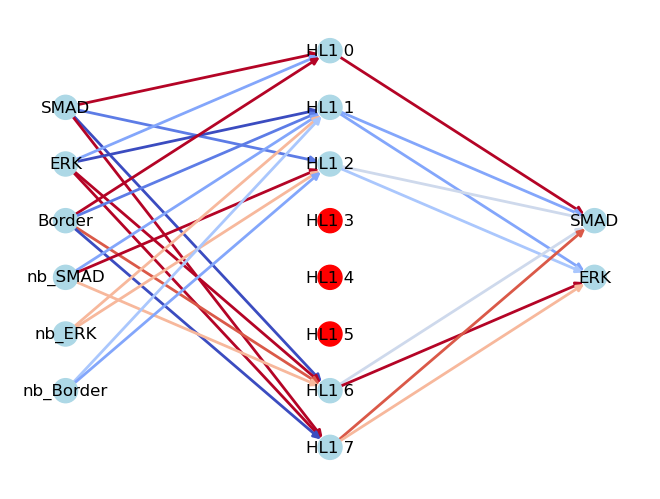

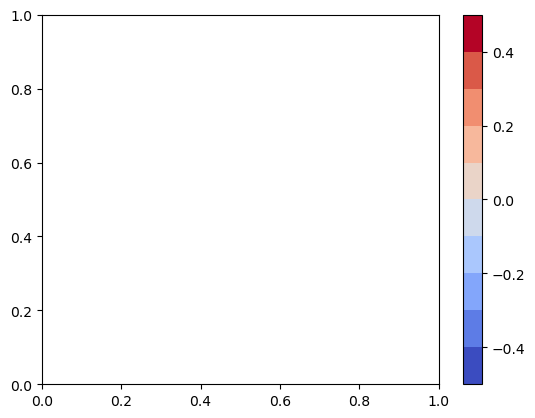

In [30]:
import networkx as nx

weights = [w.detach().numpy() for w in model.get_weights()]


sizes = [w.shape[0] for w in weights]
sizes = [weights[0].shape[1]] + sizes

print(sizes)

G = nx.complete_multipartite_graph(*sizes)
pos = nx.multipartite_layout(G)

DG = G.to_directed()

# remove all edges
DG.remove_edges_from(list(DG.edges()))

# find nodes in each layer
nodes_in_subsets = [[] for _ in range(len(sizes))]
for node in DG.nodes(data=True):
    subset = node[1]['subset']
    nodes_in_subsets[subset].append(node[0])

prune_masks = []
# remove edges with small weights
for weight_matrix_i in range(len(weights)):
    weight_matrix = weights[weight_matrix_i]

    weight_matrix_iii = weight_matrix_i #+ (-1 if weight_matrix_i != 0 else 0) # beacause first two are for same layer

    edges_to_add = []
    mean_mag = np.mean(np.abs(weight_matrix))

    to_remove_mask = np.ones_like(weight_matrix, dtype=bool)
    for i, w in enumerate(weight_matrix):
        mean_mag_row = np.mean(np.abs(w))
        for j, w_ in enumerate(w):
            sens = 0.3
            if np.abs(w_) > sens*mean_mag and np.abs(w_) > sens*mean_mag_row:
                edges_to_add.append((nodes_in_subsets[weight_matrix_iii][j], nodes_in_subsets[weight_matrix_iii+1][i], {"weight":w_}))
                to_remove_mask[i, j] = False

    DG.add_edges_from(edges_to_add)

    prune_masks.append(to_remove_mask)
    plt.imshow(weight_matrix)
    plt.colorbar()
    plt.scatter(np.where(to_remove_mask)[1], np.where(to_remove_mask)[0], c='r')
    plt.show()


# # remove nodes with no outgoing edges or incoming edges
node_colors = []
for node in DG.nodes(data=True):
    col = "lightblue"
    if len(list(DG.in_edges(node[0]))) == 0 and not node[1]['subset'] == 0:
        col = 'r'
    elif len(list(DG.out_edges(node[0]))) == 0 and not node[1]['subset'] == len(sizes)-1:
        col = 'r'

    node_colors.append(col)

# color the edges based on the weight matrix


labels = {}

for node in nodes_in_subsets[0]:
    n = node - nodes_in_subsets[0][0]
    names  = ["SMAD", "ERK", "Border", "nb_SMAD", "nb_ERK", "nb_Border"]
    # names  = ["SMAD", "Border", "nb SMAD", "nb Border", "nb_ERK", "nb_Border"]
    labels[node] = names[n]

for node in nodes_in_subsets[-1]:
    n = node - nodes_in_subsets[-1][0]
    names = ["SMAD", "ERK"]
    labels[node] = names[n]

for i in range(1, len(sizes)-1):
    for node in nodes_in_subsets[i]:
        n = node - nodes_in_subsets[i][0]
        labels[node] = f"HL{i} {n}"
        

        
# discrete colormap
cmap = plt.cm.coolwarm
# Create a discrete colormap
cmap = plt.cm.get_cmap('coolwarm', 10)


vmin, vmax = -.5, .5


edges = DG.edges(data=True)
plotweights = [edge[2]['weight'] for edge in edges]
nx.draw(DG, pos, with_labels=True, node_color=node_colors, edge_color=plotweights, edge_cmap=cmap, labels=labels, width=2, edge_vmin=vmin, edge_vmax=vmax)
fig, ax = plt.subplots()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
fig.colorbar(sm, ax=ax)

plt.show()



In [219]:
(weights[1]*(~prune_masks[1]))[0,:]

array([ 0.02815988, -0.        , -0.        ,  0.064207  , -0.03534834,
        0.11342628,  0.        ,  0.11198169], dtype=float32)

In [12]:
import sympy as sp

# set up the variables
S = sp.symbols('S', positive=True, real=True)
E = sp.symbols('E', positive=True, real=True)
B = sp.symbols('B', positive=True, real=True)
nb_S = sp.symbols('S_nb', positive=True, real=True)
nb_E = sp.symbols('E_nb', positive=True, real=True)
nb_B = sp.symbols('B_nb', positive=True, real=True)

inp_vec = sp.Matrix([ S, E, B, nb_S, nb_E, nb_B,])
# inp_vec = sp.Matrix([ S,B, nb_S,nb_B,])

# calculate the first layer
W0 = sp.Matrix(weights[0] * ~prune_masks[0])

X = W0*inp_vec
activation = sp.Function('sigma')

# activation = lambda x: x if x > 0 else 0
# activation = lambda x: x


XXX = []
for x in X:
    terms = sp.Add.make_args(x)
    if terms is None:
        XXX.append(x)
        continue

    if all(np.array(terms)>0):
        XXX.append(x)
        continue
    
    if all(np.array(terms)<0):
        XXX.append(0)
        continue

    XXX.append(activation(x))

# X = sp.Matrix([activation(x) for x in X])
X = sp.Matrix(XXX)

# squared

# sigmoid
# activation = lambda x: 1/(1 + sp.exp(-x))

# softplus
# activation = lambda x: sp.log(1 + sp.exp(x))


for i in range(1, len(weights)):
    W = sp.Matrix(weights[i] * ~prune_masks[i])
    X = W*X

    if i != len(weights)-1:
        X = sp.Matrix([activation(x) for x in X])

# define the activation function



# calculate the second layer

# simplify the expression


X

Matrix([
[                                                                                                                        0.0686867*E + 0.912594*S + 0.140908*S_nb + 0.421242*sigma(1.06564*B - 0.727834*E - 1.11263*S) - 0.186583*sigma(-0.0978368*B - 0.331118*B_nb + 0.365088*E + 0.204306*E_nb + 0.441431*S_nb) - 0.168905*sigma(0.291231*B + 0.385945*B_nb + 0.942245*E - 0.177871*E_nb + 0.337758*S_nb)],
[0.0121051*E + 0.160833*S + 0.0248332*S_nb - 0.118694*sigma(-0.296195*B - 0.114177*B_nb + 0.414923*S_nb) + 0.248509*sigma(1.06564*B - 0.727834*E - 1.11263*S) + 0.464118*sigma(2.18622*E - 0.550181*S + 0.258269*S_nb) - 0.118206*sigma(-0.0978368*B - 0.331118*B_nb + 0.365088*E + 0.204306*E_nb + 0.441431*S_nb) - 0.136173*sigma(0.291231*B + 0.385945*B_nb + 0.942245*E - 0.177871*E_nb + 0.337758*S_nb)]])

In [191]:
# define differences 
S_diff = sp.symbols('S_diff', positive=True, real=True)
E_diff = sp.symbols('E_diff', positive=True, real=True)
B_diff = sp.symbols('B_diff', positive=True, real=True)

X_subbed = X.subs({S: nb_S + S_diff, E: nb_E + E_diff, B: nb_B + B_diff})

simp = sp.simplify(X,)
simp[0]


0.2185*E_nb - 0.011138*S + 0.262114*S_nb + 0.064207*sigma(-1.46919*B_nb - 0.338297*E + 1.8317*E_nb) + 0.113426*sigma(2.32898*B_nb - 1.49906*E_nb - 1.26453*S_nb) + 0.0281599*sigma(-0.439438*B - 0.642633*B_nb + 1.5287*E_nb + 1.13931*S_nb)

In [174]:
# create a function for the model
func = sp.lambdify([nb_S, nb_E, nb_B, S, E, B], simp[0], 'numpy')

In [ ]:
func()

<function _lambdifygenerated(S_nb, E_nb, B_nb, S, E, B)>

In [ ]:
func

<function _lambdifygenerated(S_nb, E_nb, B_nb, S, E, B)>